# Fashion Forward Forecasting (StyleSense)
End-to-end ML pipeline (EDA → Train/Tune → Evaluate → Save) for Udacity DSND: Machine Learning Pipelines Project.

In [1]:
import sys, sklearn, pandas as pd, numpy as np, matplotlib
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("sklearn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.12.1
sklearn: 1.7.2
pandas: 2.3.3
numpy: 2.3.4
matplotlib: 3.10.3


In [2]:
from pathlib import Path
import json
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

import warnings
warnings.filterwarnings("ignore")  # keep notebook clean
matplotlib.rcParams["figure.dpi"] = 120


In [3]:
# Adjust paths if needed
CSV_PATH = "starter/data/reviews.csv"
TARGET   = "Recommended IND"
TEXTCOL  = "Review Text"

df = pd.read_csv(CSV_PATH)
df.head()

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


In [4]:
summary = {
    "shape": df.shape,
    "columns": df.columns.tolist(),
    "missing_pct_top10": df.isna().mean().sort_values(ascending=False).head(10).to_dict(),
    "target_counts": df[TARGET].value_counts(dropna=False).to_dict(),
    "target_proportions": df[TARGET].value_counts(normalize=True, dropna=False).round(4).to_dict(),
}
print(json.dumps(summary, indent=2))

{
  "shape": [
    18442,
    9
  ],
  "columns": [
    "Clothing ID",
    "Age",
    "Title",
    "Review Text",
    "Positive Feedback Count",
    "Division Name",
    "Department Name",
    "Class Name",
    "Recommended IND"
  ],
  "missing_pct_top10": {
    "Clothing ID": 0.0,
    "Age": 0.0,
    "Title": 0.0,
    "Review Text": 0.0,
    "Positive Feedback Count": 0.0,
    "Division Name": 0.0,
    "Department Name": 0.0,
    "Class Name": 0.0,
    "Recommended IND": 0.0
  },
  "target_counts": {
    "1": 15053,
    "0": 3389
  },
  "target_proportions": {
    "1": 0.8162,
    "0": 0.1838
  }
}


In [5]:
def to_1d_str(x):
    import pandas as pd
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    x = pd.Series(x).fillna("").astype(str)
    return x.values

In [6]:
num_cols = ["Age", "Positive Feedback Count"]
cat_cols = ["Division Name", "Department Name", "Class Name"]
text_col = TEXTCOL

X = df[num_cols + cat_cols + [text_col]]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((14753, 6), (3689, 6))

In [7]:
# Numeric
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=False)),  # sparse-friendly
])

# Categorical
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

# Text
txt_pipe = Pipeline([
    ("sel", FunctionTransformer(to_1d_str, validate=False)),
    ("tfidf", TfidfVectorizer(
        max_features=20000,    # tuned
        ngram_range=(1, 2),    # tuned
        stop_words="english",
        strip_accents="unicode"
    ))
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("txt", txt_pipe, [text_col]),
    ],
    remainder="drop"
)

clf = LogisticRegression(max_iter=500)
pipe = Pipeline([("pre", pre), ("clf", clf)])

pipe


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
param_grid = {
    "pre__txt__tfidf__max_features": [10000, 20000],
    "pre__txt__tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score=True
)

grid.fit(X_train, y_train)
print("Best F1 (CV):", grid.best_score_)
print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best F1 (CV): 0.9311546372865441
Best Params: {'clf__C': 2.0, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'pre__txt__tfidf__max_features': 10000, 'pre__txt__tfidf__ngram_range': (1, 2)}


In [9]:
best = grid.best_estimator_

y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:, 1] if hasattr(best.named_steps["clf"], "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
cm  = confusion_matrix(y_test, y_pred)

print(json.dumps({
    "accuracy": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1": round(f1, 4),
    "roc_auc": None if roc is None else float(roc)
}, indent=2))

print("\nClassification report:")
print(classification_report(y_test, y_pred))


{
  "accuracy": 0.8878,
  "precision": 0.9024,
  "recall": 0.9671,
  "f1": 0.9336,
  "roc_auc": 0.9267812514389226
}

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       678
           1       0.90      0.97      0.93      3011

    accuracy                           0.89      3689
   macro avg       0.84      0.75      0.79      3689
weighted avg       0.88      0.89      0.88      3689



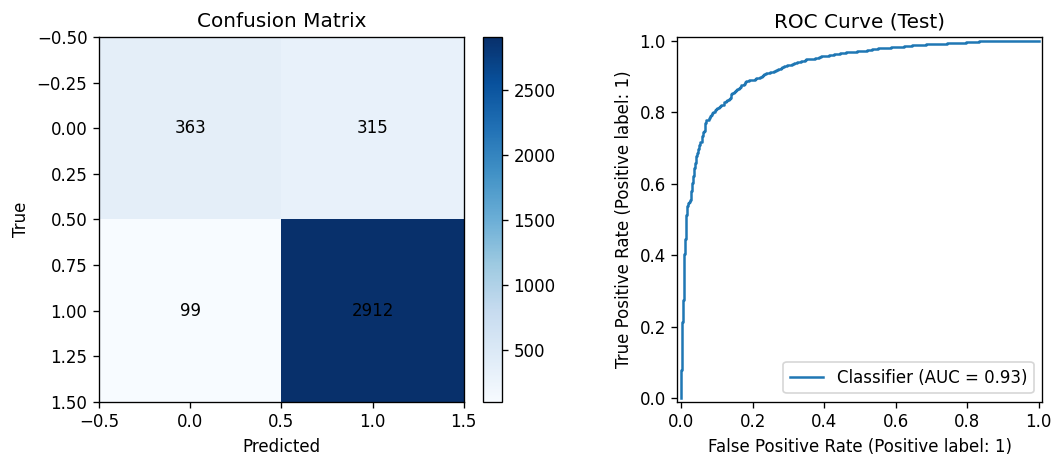

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Confusion Matrix
im = ax[0].imshow(cm, cmap="Blues")
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax[0].text(j, i, str(v), ha="center", va="center", color="black")
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

# ROC
if y_proba is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax[1])
    ax[1].set_title("ROC Curve (Test)")
else:
    ax[1].text(0.5, 0.5, "No probabilities available", ha="center")

plt.tight_layout()
plt.show()


In [11]:
outdir = Path("models")
(outdir / "figures").mkdir(parents=True, exist_ok=True)

joblib.dump(best, outdir / "best_pipeline.joblib")
with open(outdir / "best_params.json", "w") as f:
    json.dump(grid.best_params_, f, indent=2)

results = {
    "test_accuracy": float(acc),
    "test_precision": float(prec),
    "test_recall": float(rec),
    "test_f1": float(f1),
    "test_roc_auc": None if roc is None else float(roc),
    "confusion_matrix": cm.tolist()
}
with open(outdir / "test_report.json", "w") as f:
    json.dump(results, f, indent=2)

# Save figures
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center", color="black")
plt.tight_layout()
plt.savefig(outdir / "figures" / "confusion_matrix.png", dpi=150)
plt.close()

if y_proba is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve (Test)")
    plt.tight_layout()
    plt.savefig(outdir / "figures" / "roc_curve.png", dpi=150)
    plt.close()

print("Saved to:", outdir.resolve())


Saved to: /workspaces/dsnd-pipelines-project/models


## 🧠 Model Card

**Intended Use:** Predict customer recommendations for women’s fashion products on StyleSense to analyze satisfaction and detect trends.

**Training Data:** ~18k reviews (text + metadata). Features: Age, Division/Department/Class, Review Text.

**Model:** sklearn Pipeline (Impute/Scale, OHE, TF-IDF) + LogisticRegression tuned via GridSearchCV.

**Limitations:** Trained on women’s apparel; may not generalize to other domains. Text sentiment may reflect linguistic/cultural bias.

**Ethical Considerations:** Use predictions to augment, not replace, human judgment. Consider fairness and context in decisions.
